<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/XceptionModifiedAsymmetricConvolutionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tr
import numpy as np 
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct  9 08:33:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} isavailable')
# GPU 사용 할 것임

cuda:0 isavailable


In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x
    

class SeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SeparableConv, self).__init__()
        
        # 1x3 필터를 통한 공간 연산, 인풋 채널과 아웃풋 채널을 같게 해서 채널은 가만히 둔다. groups 변수 중요.
        #-> padding을 잘 주어야한다. 아니면 인풋과 아웃풋의 이미지 사이즈가 달라져서 학습이 되지 않는다. 
        self.depthwise1 = nn.Conv2d(in_ch, in_ch, kernel_size=(1,3), stride=1, padding=(0,1), groups=in_ch, bias=False)
        self.depthwise2 = nn.Conv2d(in_ch, in_ch, kernel_size=(3,1), stride=1, padding=(1,0), groups=in_ch, bias=False)
        
        # 1x1 필터를 통한 채널 연산, 필터 크기를 1x1로 해서 공간(feature map 크기)은 가만히 둔다
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        x = self.depthwise1(x)
        x = self.depthwise2(x)
        x = self.pointwise(x)
        x = self.bn(x)
        
        return x

In [6]:
# Entry Flow    

class Entry(nn.Module):
    def __init__(self):
        super(Entry, self).__init__()
        
        self.relu = nn.ReLU()
        
        self.conv_32 = ConvBlock(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv_64 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_64 = ConvBlock(64, 128, kernel_size=1, stride=2, padding=0)
        self.conv1x1_128 = ConvBlock(128, 256, kernel_size=1, stride=2, padding=0)
        self.conv1x1_256 = ConvBlock(256, 728, kernel_size=1, stride=2, padding=0)
        
        self.sepconv1 = SeparableConv(64, 128)
        self.sepconv2 = SeparableConv(128, 128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.sepconv3 = SeparableConv(128, 256)
        self.sepconv4 = SeparableConv(256, 256)
        
        self.sepconv5 = SeparableConv(256, 728)
        self.sepconv6 = SeparableConv(728, 728)
        
    def forward(self, x):
        
        x = self.conv_32(x)
        x = self.conv_64(x)
        
        pre_x1 = x
        pre_x1 = self.conv1x1_64(x) #첫 번째 블록
        
        x = self.sepconv1(x)
        
        x = self.relu(x)        
        x = self.sepconv2(x)
        
        x = self.maxpool(x) # 2번째 블록
        
        pre_x2 = x #2번째 블록 기억 
        pre_x2 = self.conv1x1_128(x)
        
        x = self.relu(x+pre_x1) #1번째 2번째 더한 것에 reLu
        x = self.sepconv3(x)  #3번째 separable 
        
        x = self.relu(x)
        x = self.sepconv4(x)
        
        x = self.maxpool(x)
        
        pre_x3 = x
        pre_x3 = self.conv1x1_256(x)
        
        x = self.relu(x+pre_x2)
        x = self.sepconv5(x)
        
        x = self.relu(x)
        x = self.sepconv6(x)
        
        x = self.maxpool(x)
        
        return x+pre_x3

PYTORCH
nn.ReLU()함수 사용법


In [7]:
entry = Entry().to(device)
if __name__ == '__main__':

    from torchsummary import summary
    model = Entry().to(device)
    summary(model, (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              ReLU-3         [-1, 32, 150, 150]               0
         ConvBlock-4         [-1, 32, 150, 150]               0
            Conv2d-5         [-1, 64, 150, 150]          18,432
       BatchNorm2d-6         [-1, 64, 150, 150]             128
              ReLU-7         [-1, 64, 150, 150]               0
         ConvBlock-8         [-1, 64, 150, 150]               0
            Conv2d-9          [-1, 128, 75, 75]           8,192
      BatchNorm2d-10          [-1, 128, 75, 75]             256
             ReLU-11          [-1, 128, 75, 75]               0
        ConvBlock-12          [-1, 128, 75, 75]               0
           Conv2d-13         [-1, 64, 150, 150]             192
           Conv2d-14         [-1, 64, 1

In [8]:
# Middle Flow

class Middle(nn.Module):
    def __init__(self):
        super(Middle, self).__init__()
        
        self.relu = nn.ReLU()
        self.sepconv = SeparableConv(728, 728)
        
    def forward(self, x):
        
        pre_x = x
        
        for _ in range(3):
            x = self.relu(x)
            x = self.sepconv(x)
        
        return x+pre_x

In [9]:
if __name__ == '__main__':

    from torchsummary import summary
    model = Middle().to(device)
    summary(model, (728,19,19))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1          [-1, 728, 19, 19]               0
            Conv2d-2          [-1, 728, 19, 19]           2,184
            Conv2d-3          [-1, 728, 19, 19]           2,184
            Conv2d-4          [-1, 728, 19, 19]         529,984
       BatchNorm2d-5          [-1, 728, 19, 19]           1,456
     SeparableConv-6          [-1, 728, 19, 19]               0
              ReLU-7          [-1, 728, 19, 19]               0
            Conv2d-8          [-1, 728, 19, 19]           2,184
            Conv2d-9          [-1, 728, 19, 19]           2,184
           Conv2d-10          [-1, 728, 19, 19]         529,984
      BatchNorm2d-11          [-1, 728, 19, 19]           1,456
    SeparableConv-12          [-1, 728, 19, 19]               0
             ReLU-13          [-1, 728, 19, 19]               0
           Conv2d-14          [-1, 728,

In [10]:
# Exit Flow

class Exit(nn.Module):
    def __init__(self):
        super(Exit, self).__init__()
        
        self.relu = nn.ReLU()
        self.conv1x1_728 = ConvBlock(728, 1024, kernel_size=1, stride=2, padding=0)
        
        self.sepconv1 = SeparableConv(728, 728)
        self.sepconv2 = SeparableConv(728, 1024)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.sepconv3 = SeparableConv(1024, 1536)
        self.sepconv4 = SeparableConv(1536, 2048)
        
        self.dropout = nn.Dropout(0.5)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(2048, 1000)
        
    def forward(self, x):
        
        pre_x = x
        pre_x = self.conv1x1_728(x)
        
        x = self.relu(x)
        x = self.sepconv1(x)
        
        x = self.relu(x)
        x = self.sepconv2(x)
        
        x = self.maxpool(x)
        
        x = self.sepconv3(pre_x+x)
        x = self.relu(x)
        
        x = self.sepconv4(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        
        return x

In [11]:
if __name__ == '__main__':

    from torchsummary import summary
    model = Exit().to(device)
    summary(model, (728,19,19))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 10, 10]         745,472
       BatchNorm2d-2         [-1, 1024, 10, 10]           2,048
              ReLU-3         [-1, 1024, 10, 10]               0
         ConvBlock-4         [-1, 1024, 10, 10]               0
              ReLU-5          [-1, 728, 19, 19]               0
            Conv2d-6          [-1, 728, 19, 19]           2,184
            Conv2d-7          [-1, 728, 19, 19]           2,184
            Conv2d-8          [-1, 728, 19, 19]         529,984
       BatchNorm2d-9          [-1, 728, 19, 19]           1,456
    SeparableConv-10          [-1, 728, 19, 19]               0
             ReLU-11          [-1, 728, 19, 19]               0
           Conv2d-12          [-1, 728, 19, 19]           2,184
           Conv2d-13          [-1, 728, 19, 19]           2,184
           Conv2d-14         [-1, 1024,

In [12]:
class Xception(nn.Module):    
    def __init__(self):
        super(Xception, self).__init__()
        
        self.entry = Entry()
        self.middle = Middle()
        self.exit = Exit()
        
    def forward(self, x):
        
        x = self.entry(x)        
        for _ in range(8):
            x = self.middle(x)  # Middle Flow는 8번 수행           
        x = self.exit(x)
        
        return x

In [13]:
if __name__ == '__main__':

    from torchsummary import summary
    xception = Xception().to(device)
    summary(xception, (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              ReLU-3         [-1, 32, 150, 150]               0
         ConvBlock-4         [-1, 32, 150, 150]               0
            Conv2d-5         [-1, 64, 150, 150]          18,432
       BatchNorm2d-6         [-1, 64, 150, 150]             128
              ReLU-7         [-1, 64, 150, 150]               0
         ConvBlock-8         [-1, 64, 150, 150]               0
            Conv2d-9          [-1, 128, 75, 75]           8,192
      BatchNorm2d-10          [-1, 128, 75, 75]             256
             ReLU-11          [-1, 128, 75, 75]               0
        ConvBlock-12          [-1, 128, 75, 75]               0
           Conv2d-13         [-1, 64, 150, 150]             192
           Conv2d-14         [-1, 64, 1

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception.parameters(), lr=0.001)

# 데이터 불러오기(CIFAR-10)


In [15]:
transform = tr.Compose(
    [tr.ToTensor(),
     tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


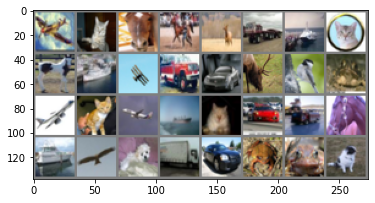

plane cat   horse horse deer  truck ship  cat   horse ship  plane truck car   deer  bird  frog  plane cat   plane ship  cat   car   truck horse ship  bird  dog   truck car   frog  frog  dog  


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
print(trainLoader)

In [18]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainLoader) # 배치 개수

for epoch in range(50):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = xception(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainLoader)))

print('Finished Training')

[1] loss: 1.558
[2] loss: 1.137
[3] loss: 0.933
[4] loss: 0.802
[5] loss: 0.689
[6] loss: 0.597
[7] loss: 0.545
[8] loss: 0.476
[9] loss: 0.415
[10] loss: 0.426
[11] loss: 0.355
[12] loss: 0.305
[13] loss: 0.253
[14] loss: 0.265
[15] loss: 0.207
[16] loss: 0.201
[17] loss: 0.164
[18] loss: 0.148
[19] loss: 0.148
[20] loss: 0.140
[21] loss: 0.116
[22] loss: 0.128
[23] loss: 0.101
[24] loss: 0.126
[25] loss: 0.135
[26] loss: 0.157
[27] loss: 0.083
[28] loss: 0.083
[29] loss: 0.097
[30] loss: 0.077
[31] loss: 0.106
[32] loss: 0.090
[33] loss: 0.075
[34] loss: 0.084
[35] loss: 0.067
[36] loss: 0.070
[37] loss: 0.068
[38] loss: 0.081
[39] loss: 0.067
[40] loss: 0.060
[41] loss: 0.070
[42] loss: 0.062
[43] loss: 0.072
[44] loss: 0.051
[45] loss: 0.063
[46] loss: 0.076
[47] loss: 0.058
[48] loss: 0.051
[49] loss: 0.043
[50] loss: 0.061
Finished Training


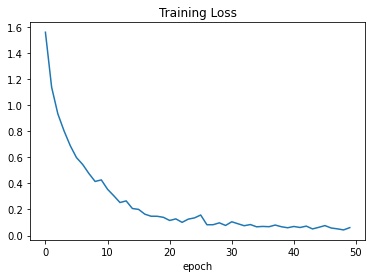

In [19]:
import matplotlib.pyplot as plt
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [20]:
PATH = './cifar_asymmetricModified.pth'
torch.save(xception.state_dict(), PATH)

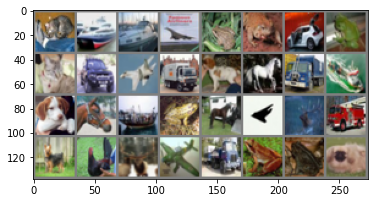

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [21]:
dataiter = iter(testLoader)
images, labels = dataiter.next()

# 이미지를 출력한다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [22]:
xceptAsymmetric = Xception()
xceptAsymmetric.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))

Predicted:  cat   dog   cat   plane frog  bird  bird  plane frog  deer  truck deer  dog   car   bird  cat  


In [25]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없다
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산한다
        outputs = xceptAsymmetric(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택한다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %


In [27]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않다
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = xceptAsymmetric(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모은다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력한다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 83.2 %
Accuracy for class: car   is 89.4 %
Accuracy for class: bird  is 71.6 %
Accuracy for class: cat   is 59.4 %
Accuracy for class: deer  is 75.0 %
Accuracy for class: dog   is 63.0 %
Accuracy for class: frog  is 82.0 %
Accuracy for class: horse is 75.2 %
Accuracy for class: ship  is 85.7 %
Accuracy for class: truck is 84.5 %
